# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (12,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Indest Data

In [10]:
df = pd.read_csv('Frozen_Dessert_Production.csv', parse_dates=['DATE'], index_col='DATE')

In [11]:
df

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [16]:
df.columns = ['Production'] # Rename the column as Production

<AxesSubplot:xlabel='DATE'>

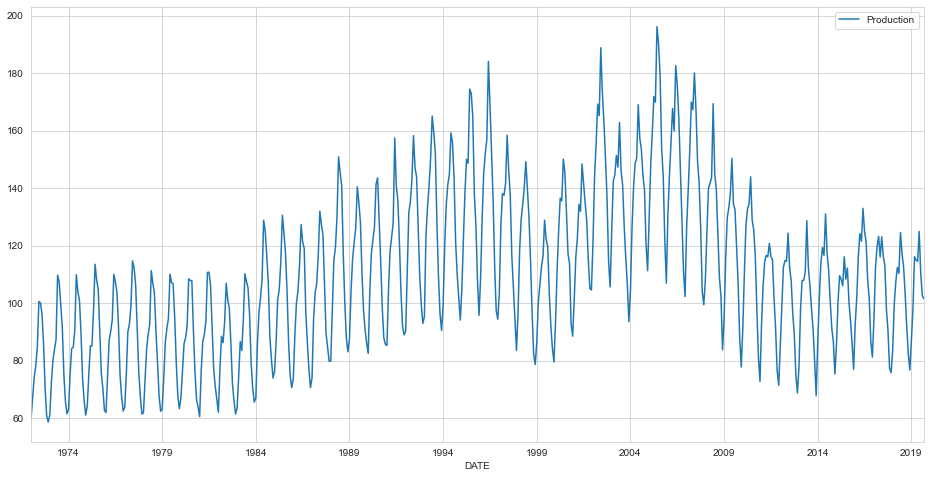

In [17]:
df.plot(figsize=(16,8)) # plot the data

In [18]:
df.duplicated().sum() # No duplicates

0

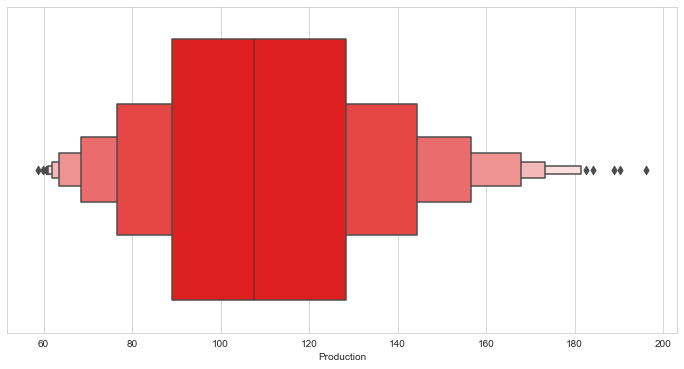

In [30]:
sns.boxenplot(df['Production'], color="red" ); # Box plot

## Preprocessing of Data

### Train Test Split

In [31]:
len(df)

573

In [32]:
test_size = 24 # 24 months 

In [35]:
test_ind = len(df) -test_size 
test_ind        

549

In [36]:
train = df.iloc[:test_ind] # Training data
test = df.iloc[test_ind:] # Testing data

In [37]:
train

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2017-05-01,116.064
2017-06-01,123.087
2017-07-01,116.264


In [41]:
test.head()

,Production
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490


### Scaling

In [42]:
from sklearn.preprocessing import MinMaxScaler

In [43]:
scaler = MinMaxScaler()

In [45]:
train_scaled = scaler.fit_transform(train) # Scaling the training data
test_scaled = scaler.transform(test)        # Scaling the testing data

## Time Series Generator

In [46]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [47]:
length = 12 # 12 months
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=length, batch_size=batch_size)

In [49]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

In [51]:
X, y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Creating Model

### with "tanh" activation function

In [81]:
n_features = train_scaled.shape[1]

In [82]:
model = Sequential() 
model.add(LSTM(100, activation='tanh', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


#### EarlyStopping and Validation Generator

In [84]:
from tensorflow.keras.callbacks import EarlyStopping

In [85]:
early_stop = EarlyStopping(monitor='val_loss', patience=10) # patience: number of epochs with no improvement after which training will be stopped.

In [86]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length=length, batch_size=batch_size)

In [87]:
model.fit(generator, epochs=50, callbacks=[early_stop], validation_data=validation_generator) 

Epoch 1/50
537/537 [==============================] - 4s 4ms/step - loss: 0.0221 - val_loss: 0.0030
Epoch 2/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 3/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 4/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 5/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 6/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 7/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 8/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 9/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 10/50
537/537 [==============================] - 2s 4ms/step - loss: 0.0032 - val_loss: 0.0021

<AxesSubplot:>

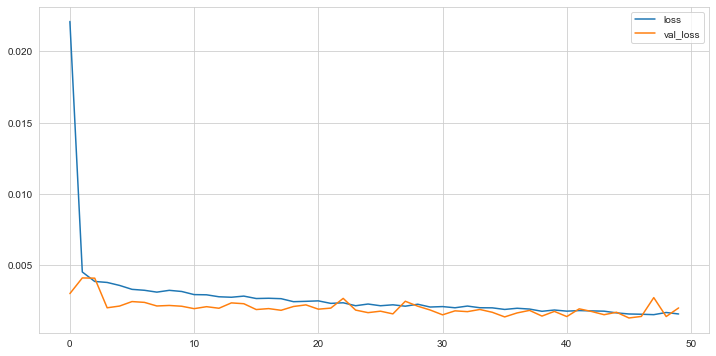

In [88]:
loss_df = pd.DataFrame(model.history.history)   
loss_df.plot()                                  

#### Evaluate on Test Data

In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [90]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [91]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [92]:
predictions_scaled

[array([0.24065879], dtype=float32),
 array([0.21096861], dtype=float32),
 array([0.22190312], dtype=float32),
 array([0.29704607], dtype=float32),
 array([0.38513252], dtype=float32),
 array([0.4455744], dtype=float32),
 array([0.49905747], dtype=float32),
 array([0.55578166], dtype=float32),
 array([0.5503108], dtype=float32),
 array([0.5091433], dtype=float32),
 array([0.44189996], dtype=float32),
 array([0.3652324], dtype=float32)]

In [93]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.2985780382258907 
mae: 0.08412055403430331 
mse: 0.008747179927205204 
rmse: 0.09352635953144549


#### Inverse Transformations and Comparing

In [94]:
predictions = scaler.inverse_transform(predictions_scaled)

In [95]:
compare = test[:12]
compare['Predictions'] = predictions
compare

,Production,Predictions
DATE,,
2017-10-01,90.473,91.754
2017-11-01,77.438,87.671
2017-12-01,75.812,89.175
2018-01-01,83.434,99.508
2018-02-01,99.490,111.621
2018-03-01,107.315,119.932
2018-04-01,112.431,127.287
2018-05-01,110.354,135.088
2018-06-01,124.584,134.335


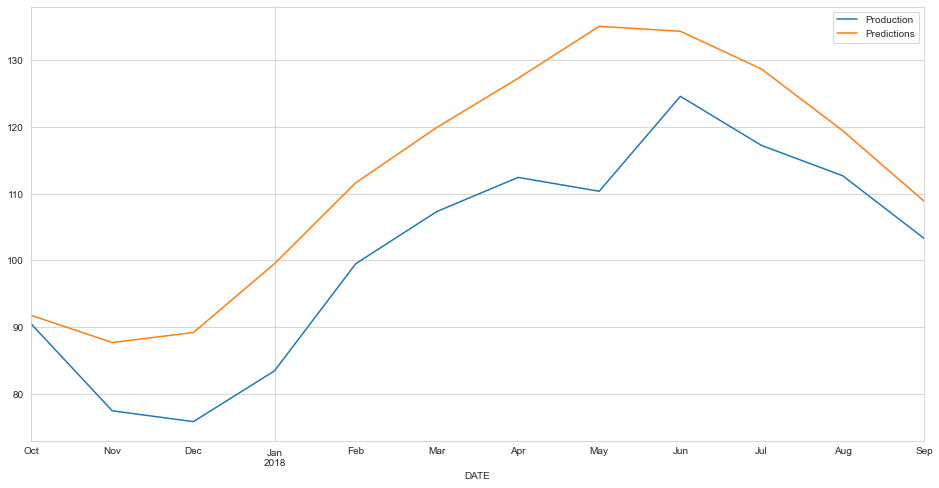

In [97]:
compare.plot(figsize=(16,8));

#### Calculation R2 Score and Error Metrics

In [99]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.2985780382258917 
mae: 11.567745455417779 
mse: 165.4098082840376 
rmse: 12.861174451971236


### with "relu" activation function

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [105]:
n_features = train_scaled.shape[1]

In [107]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [108]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               40800     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [109]:
from tensorflow.keras.callbacks import EarlyStopping

In [110]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

In [111]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [112]:
model.fit(generator, epochs = 50, callbacks = [early_stop], validation_data = validation_generator)

Epoch 1/50
537/537 [==============================] - 3s 4ms/step - loss: 0.0285 - val_loss: 0.0086
Epoch 2/50
537/537 [==============================] - 2s 3ms/step - loss: 0.0113 - val_loss: 0.0029
Epoch 3/50
537/537 [==============================] - 2s 3ms/step - loss: 0.0065 - val_loss: 0.0031
Epoch 4/50
537/537 [==============================] - 2s 3ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 5/50
537/537 [==============================] - 2s 3ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 6/50
537/537 [==============================] - 2s 3ms/step - loss: 0.0046 - val_loss: 0.0137
Epoch 7/50
537/537 [==============================] - 2s 3ms/step - loss: 0.0041 - val_loss: 0.0021
Epoch 8/50
537/537 [==============================] - 2s 3ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 9/50
537/537 [==============================] - 2s 3ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 10/50
537/537 [==============================] - 2s 3ms/step - loss: 0.0035 - val_loss: 0.0016

<AxesSubplot:>

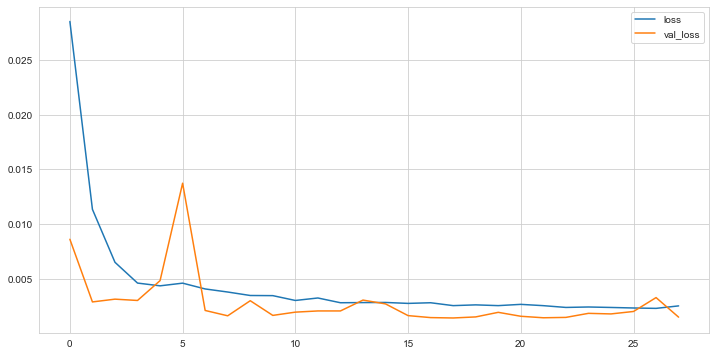

In [113]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [114]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [115]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.7167149485162942 
mae: 0.04969297288461914 
mse: 0.003532745552688551 
rmse: 0.05943690396284577


***CONCLUSION: Estimation with TANH was not a good choice. (For this data)***

#### Inverse Transformations and Comparing

In [116]:
predictions = scaler.inverse_transform(predictions_scaled)

In [117]:
compare = test[:12]
compare['Predictions'] = predictions
compare

,Production,Predictions
DATE,,
2017-10-01,90.473,91.842
2017-11-01,77.438,84.955
2017-12-01,75.812,84.978
2018-01-01,83.434,96.078
2018-02-01,99.490,107.603
2018-03-01,107.315,115.300
2018-04-01,112.431,122.277
2018-05-01,110.354,126.054
2018-06-01,124.584,126.663


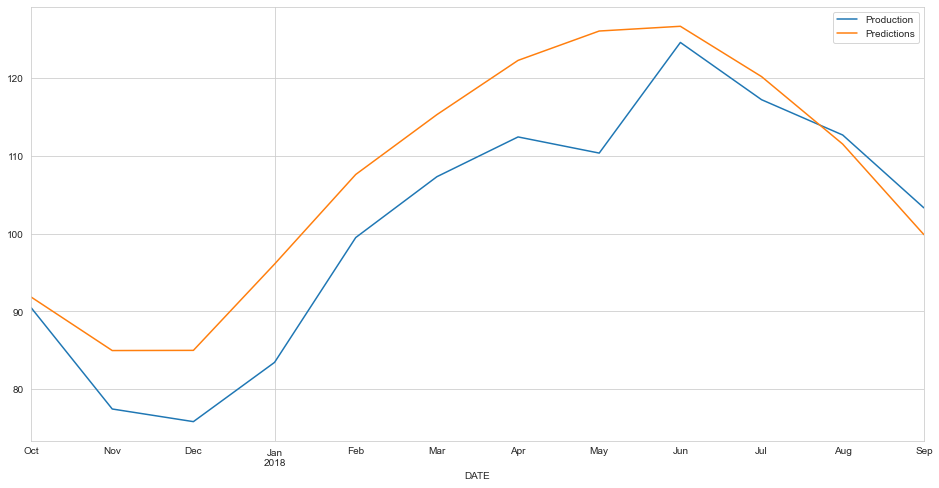

In [118]:
compare.plot(figsize=(16,8));

#### Calculation R2 Score and Error Metrics

In [119]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.7167149485162948 
mae: 6.833474503958219 
mse: 66.80447520795474 
rmse: 8.173400467856371


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [120]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [124]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=batch_size)

In [125]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator, epochs=28, verbose=1)

Epoch 1/28
561/561 [==============================] - 2s 3ms/step - loss: 0.0194
Epoch 2/28
561/561 [==============================] - 2s 3ms/step - loss: 0.0077
Epoch 3/28
561/561 [==============================] - 2s 3ms/step - loss: 0.0052
Epoch 4/28
561/561 [==============================] - 2s 3ms/step - loss: 0.0041
Epoch 5/28
561/561 [==============================] - 2s 3ms/step - loss: 0.0044
Epoch 6/28
561/561 [==============================] - 2s 3ms/step - loss: 0.0043
Epoch 7/28
561/561 [==============================] - 2s 3ms/step - loss: 0.0038
Epoch 8/28
561/561 [==============================] - 2s 3ms/step - loss: 0.0036
Epoch 9/28
561/561 [==============================] - 2s 3ms/step - loss: 0.0032
Epoch 10/28
561/561 [==============================] - 2s 3ms/step - loss: 0.0031
Epoch 11/28
561/561 [==============================] - 2s 3ms/step - loss: 0.0030
Epoch 12/28
561/561 [==============================] - 2s 3ms/step - loss: 0.0030
Epoch 13/28
561/561 [====

In [130]:
scaled_full_data.shape

(573, 1)

In [131]:
scaled_full_data[-length:].shape

(12, 1)

In [132]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [133]:
forecast = scaler.inverse_transform(forecast) # undo scaling

In [135]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')

In [136]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [137]:
forecast_df

,Forecast
2019-10-01,87.754
2019-11-01,80.795
2019-12-01,79.871
2020-01-01,88.362
2020-02-01,99.526
2020-03-01,108.765
2020-04-01,114.362
2020-05-01,118.919
2020-06-01,121.676
2020-07-01,115.386


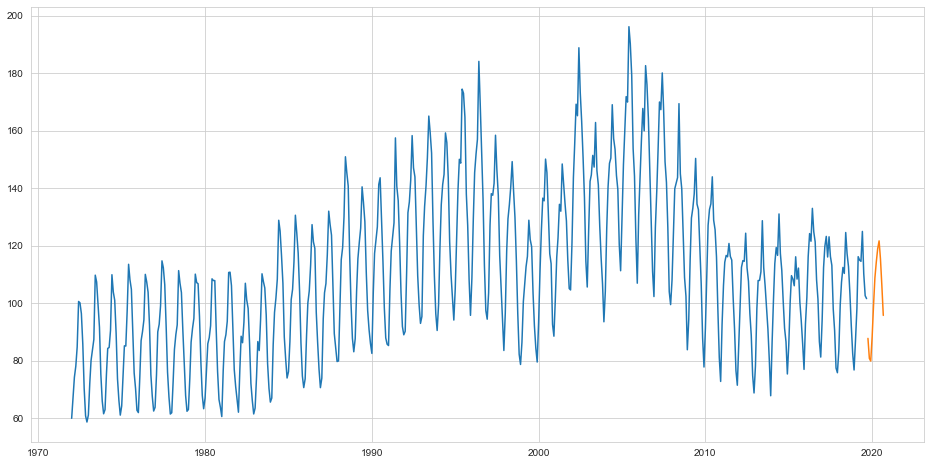

In [141]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Production'])
plt.plot(forecast_df.index, forecast_df['Forecast']);

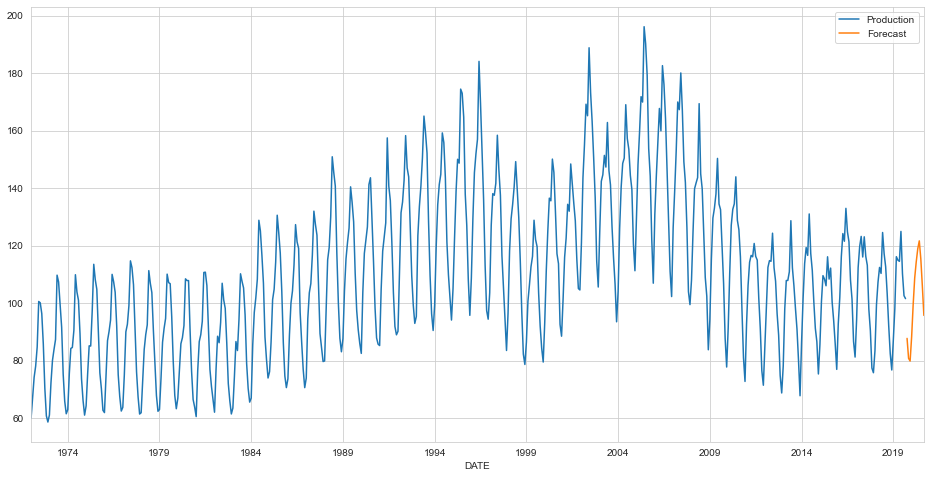

In [140]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));